# Stacked LSTM

This is from the second model type of Jason Brownlee's book on LSTMs.


This type of model apparently has better predictive capabilities than the initial model type that had only one LSTM layer. The test dataset we will be creating, and working on, is called the damped sine wave prediction problem.


### Why increase depth?
Doing so turns our model into a deep learning technique. Each layer processes the data before passing it on. It truly is an assembly line, where at the end we have our finished product. 


We could in theory have one giant layer that handles the job, but increasing the depth is more consistently optimal. The goal of any model is to approximate a function, and apparently **depth is better at that than a shallow model**.




# Implementation in Keras
To stack models the LSTM needs to output a 3D shape. I'm not really sure what it outputs naitively :\

To do so, we can just flip the ```return_sequences=True```

In [172]:
# Necessary model imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd

# Necessary graphing imports
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Necessary misc imports
import math
import random as rand

# I also want to hide stinky warning boxes, and 
# this: https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
# had some solutions.
def hide_warnings():
    from IPython.display import HTML
    HTML('''<script>
    var code_show_err = false; 
    var code_toggle_err = function() {
     var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
     var stderr = Array.from(stderrNodes)
     if (code_show_err){
         stderr.forEach(ele => ele.style.display = 'block');
     } else {
         stderr.forEach(ele => ele.style.display = 'none');
     }
     code_show_err = !code_show_err
    } 
    document.addEventListener('DOMContentLoaded', code_toggle_err);
    </script>
    To toggle on/off output_stderr, click <a onclick="javascript:code_toggle_err()">here</a>.''')
    
hide_warnings()
###########################################################

In [7]:
# definition of the model
model = Sequential()
model.add(LSTM(1, return_sequences=True, input_shape=(3,1)))
model.compile(optimizer='adam', loss='mse')

# input time steps
data = np.array([1.0, 2.0, 3.0]).reshape((1,3,1))
# Make a prediction
print(model.predict(data))

[[[0.08024395]
  [0.19221497]
  [0.29489356]]]


OOO, do you see! This outputs 1 value for every input timestep we have given it! Not exactly sure how this is useful, but I guess it is now another roll of film for the next LSTM in the sequence!

So to define a stacked LSTM all we would need to do is
```python
model.add(LSTM(3, return_sequences=True, input_shape=(3,1)))
model.add(LSTM(3, return_sequences=True) )
model.add(LSTM(3))
```

# Toy problem --- Damped Sine Wave
A normal sine wave has a periodic behavior. This occilation can be learned by an LSTM if we treat it as a simple time course. Here is an example of a normal sine wave
### Sine Wave

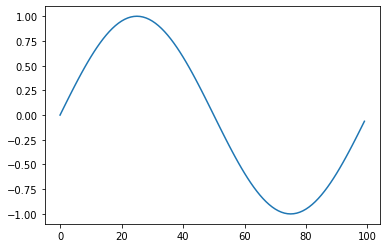

In [12]:
# Making the sequence
length=100
freq = 1
sequence = [math.sin(2*math.pi*freq*(i/length)) for i in range(length)]

# Plotting it
plt.plot(sequence)
plt.
plt.show()

---
A damped sinewave has decreasing amplitudes the further it goes. This requires another level of abstraction that the Vanilla LSTM may struggle with. 

### Damped Sine Wave (my implementation)

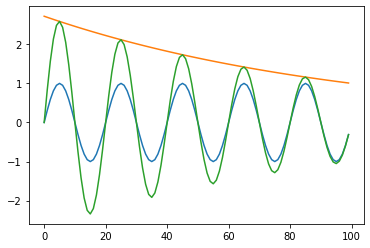

In [41]:
# initializing the model
length = 100
freq = 5
decay = 0.01
sequence = [math.sin(2*math.pi*freq*(i/length)) for i in range(length)]
# Made this by trial and error
sequence2 = [ (math.e ** (1-(decay*i))) for i in range(length)]
sequence3 = np.array(sequence) * np.array(sequence2)
# Plotting the sequence
plt.plot(sequence)
plt.plot(sequence2)
plt.plot(sequence3)

### Damped Sine Wave (book implementation)

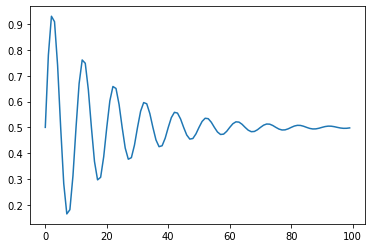

In [45]:
# Initializing the model
length = 100
period = 10
decay = 0.05
sequence = [0.5 + 0.5 * math.sin(2*math.pi*i/period) * np.exp(-decay * i) for i in range(length)]

# Plotting the sequence
plt.plot(sequence)
plt.show()

---
Well now lets make a bunch of random bits of this function to mimic a timecourse. We will need several functions

* generate_sequence()
* generate_examples()

### generate_sequence()

In [80]:
# Creates a random damped sine wave [0,1]
def generate_sequence(length, period, decay):
    return [0.5 + 0.5 * math.sin(2*math.pi*i/period) * math.exp(-decay * i) for i in range(length)]

In [81]:
# Generate random periods and decay values
p = rand.randint(10,20)
d = rand.uniform(0.01, 0.1)
print(p,d)

13 0.010921356731620853


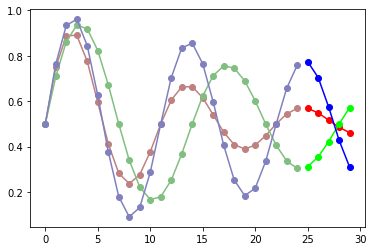

In [170]:
def generate_examples(length, n_patterns, output):
    '''Given how long we want the training input to be,
    how many training examples we want, and how long
    the output should be, generate a bunch of random 
    damped sine waves'''
    X,y = list(), list()
    
    for _ in range(n_patterns):
        p = rand.randint(10,20)
        d = rand.uniform(0.01, 0.1)
        sequence = generate_sequence(length+output, p, d)
        X.append(sequence[:-output])
        y.append(sequence[-output:])
        
    X = np.array(X).reshape(n_patterns, length, 1)
    y = np.array(y).reshape(n_patterns, output)
    
    return X,y

# Testing out generate_examples()
X,y = generate_examples(25, 3, 5)
y_line_colors = [(1,0,0), (0,1,0), (0,0,1)]
X_line_colors = [(0.75,0.5,0.5), (0.5,0.75,0.5), (0.5,0.5,0.75)]
for i in range(len(X)):
    plt.plot([x for x in X[i,:,0]], 
             '-o',
             c=X_line_colors[i])
    plt.plot([X.shape[1] + x for x in range(len(y[i]))],[x for x in y[i]],
            '-o',
            c=y_line_colors[i])

---
Wow works like a charm. The dimmer color is the training set, and the lighter color is the test/predict set. We can generate tons of lines!!! 


The book is saying this is considered a "many-to-one" model type, because the model won't output each timestep one at a time, but rather all at once, and evaluated all at once (very nice practice, thank you Mr. Brownlee).


He defines the model to have a 5 value output that will be interpreted as 5 time steps. He says to use the linear activation function! **How did he choose this! Why did he choose this!!!**

### Stacked LSTM definition

In [173]:
# Training set variables
length = 50
output = 5

# Model defintion
model = Sequential()
model.add(LSTM(20, input_shape=[length,1], return_sequences=True))
model.add(LSTM(20))
model.add(Dense(output))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50, 20)            1760      
_________________________________________________________________
lstm_7 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense (Dense)                (None, 5)                 105       
Total params: 5,145
Trainable params: 5,145
Non-trainable params: 0
_________________________________________________________________
None


---
Now we can fit the model

In [175]:
X, y = generate_examples(length, 10000, output)
model.fit(X,y, batch_size=10, epochs=1)

1000/1000 [==============================] - 27s 24ms/step - loss: 0.0645
